<h3>Comments</h3>
- Removing everythin inside of parentheses for wiki movies mismatches some movies (Candyman matched to short film instead of 2021 film) but there are to many (... film) to filter consistently<br>
- With the Wiki merge I loose some movies (F9: The Fast Saga e.g); manual insertion?<br>
- Rigor and Edits are a bit distorted since there is no way to get the edit history filtering out all non-user revisions (sometimes there might be slightly higher rigor than edits which is incorrect)<br>
- Pageviews are not correct. Now way to filter past article names and merge their views to the final title version of a wiki page<br>
- 

<br>

<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Social Media Data Analysis Project Paper</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Predicting Movie Box Office Success Based on Wikipedia Activity</h4>
</div>
<br>

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
import json
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### Wikipedia 2021 Movie List (Wikipedia Page Links)

In [24]:
def get_wiki_links(url):
    request = requests.get(url)
    soup = BeautifulSoup(request.content, 'html.parser')
    new_url = soup.find('a', href=True, string='next page')['href']
    previous_url = url

    title = []
    wiki_link = []

    while True:

        previous_url = new_url
        letters = soup.findAll('div', {'class' : 'mw-category-group'})[14:]

        for entry in letters:
            movies = entry.findAll('li')

            for movie in movies:
                title.append(movie.string)
                wiki_link.append(movie.find('a')['href'])

        try:
            new_url = soup.find('a', href=True, string='next page')['href']
        except:
            break

        request = requests.get('https://en.wikipedia.org/' + new_url)
        soup = BeautifulSoup(request.content, 'html.parser')
        
    return pd.DataFrame({'title' : title, 'wiki_page' : wiki_link})

In [25]:
wiki_2020 = get_wiki_links('https://en.wikipedia.org/wiki/Category:2020_films')
wiki_2021 = get_wiki_links('https://en.wikipedia.org/wiki/Category:2021_films')

In [26]:
wiki_df = pd.concat([wiki_2020, wiki_2021], axis=0)

In [27]:
wiki_df['title'] = wiki_df['title'].str.replace(' \(.*\)', '', regex=True)
wiki_df['wiki_page'] = wiki_df['wiki_page'].str.replace('/wiki/', '')

In [28]:
# wiki_df.to_csv('data/wikipedia_links.csv', index=False)

In [123]:
wiki_df[wiki_df['title'] == 'F9']

,title,wiki_page
2842,F9,F9_(film)


In [183]:
wiki_df[wiki_df['title'] == 'Candyman']['wiki_page'].str.replace('_\(2021_film\) | _\(short_film\)', '', regex=True)

337     Candyman_(short_film)
2529     Candyman_(2021_film)
Name: wiki_page, dtype: object

### Domestic 2021 Boxofficemojo Moivies (400/408)

In [29]:
wiki_df = pd.read_csv('data/wikipedia_links.csv')

In [30]:
def get_bom_data():
    
    titles = []
    gross = []
    theaters = []
    opening = []
    release = []
    
    url = 'https://www.boxofficemojo.com/year/2021/?grossesOption=totalGrosses&sort=rank&sortDir='
    
    for link in ['asc', 'desc']:
        request = requests.get(url + link)
        soup = BeautifulSoup(request.content, 'html.parser')
        
        soup_rows = soup.find('div', {'id' : 'table'}).findAll('tr')

        for row in soup_rows:
            i = 0
            for cell in row.findAll('td'):

                if i == 1:
                    titles.append(cell.string)

                elif i == 5:
                    gross.append(cell.string)

                elif i == 7:
                    opening.append(cell.string)
                    
                elif i == 9:
                    theaters.append(cell.string)

                elif i == 10:
                    date = cell.string + ', 2021'
                    date = datetime.strptime(date, '%b %d, %Y').strftime('%Y-%m-%d')
                    release.append(date)

                i += 1
                
    return pd.DataFrame({'title' : titles, 'gross_revenue': gross, 'n_theaters' : theaters, 'opening_revenue' : opening, 'release_date' : release})

In [31]:
bom_df = get_bom_data()
merge_df = bom_df.merge(wiki_df, on='title').drop_duplicates('title')
merge_df.head()

,title,gross_revenue,n_theaters,opening_revenue,release_date,wiki_page
0,Spider-Man: No Way Home,"$804,793,477","4,336","$260,138,569",2021-12-17,Spider-Man:_No_Way_Home
1,Shang-Chi and the Legend of the Ten Rings,"$224,543,292","4,300","$75,388,688",2021-09-03,Shang-Chi_and_the_Legend_of_the_Ten_Rings
2,Venom: Let There Be Carnage,"$213,550,366","4,225","$90,033,210",2021-10-01,Venom:_Let_There_Be_Carnage
3,Black Widow,"$183,651,655","4,160","$80,366,312",2021-07-09,Black_Widow_(2021_film)
4,Eternals,"$164,870,234","4,090","$71,297,219",2021-11-05,Eternals_(film)


### Retrieve Page Creation Date Via XTools API

In [32]:
def xtools_requests(wiki_page_name):
    url = 'https://xtools.wmcloud.org/api/page/articleinfo/en.wikipedia.org/'
    try:
        return requests.get(url + wiki_page_name)
    except:
        return 'Some error occured'

In [33]:
def get_edit_data(df, targe_column='wiki_page'):

    inceptions = []


    for i in df[targe_column]:
        data = xtools_requests(i)
        try:
            inceptions.append(data.json()['created_at'])
        except:
            inceptions.append(None)
            
    df['page_created_date'] = inceptions

In [34]:
# get_edit_data(merge_df)
# merge_df.head()

,title,gross_revenue,n_theaters,opening_revenue,release_date,wiki_page,page_created_date
0,Spider-Man: No Way Home,"$804,793,477","4,336","$260,138,569",2021-12-17,Spider-Man:_No_Way_Home,2016-11-10
1,Shang-Chi and the Legend of the Ten Rings,"$224,543,292","4,300","$75,388,688",2021-09-03,Shang-Chi_and_the_Legend_of_the_Ten_Rings,2018-12-03
2,Venom: Let There Be Carnage,"$213,550,366","4,225","$90,033,210",2021-10-01,Venom:_Let_There_Be_Carnage,2018-11-23
3,Black Widow,"$183,651,655","4,160","$80,366,312",2021-07-09,Black_Widow_(2021_film),2012-10-30
4,Eternals,"$164,870,234","4,090","$71,297,219",2021-11-05,Eternals_(film),2018-04-23


In [35]:
# merge_df.to_csv('data/movies_meta_data.csv', index=False)

### Histograms

In [4]:
df = pd.read_csv('data/movies_meta_data.csv')
df['wiki_page'] = df['wiki_page'].str.replace('/', '%2F') # replace URL reserved character '/'
df.head()

,title,gross_revenue,n_theaters,opening_revenue,release_date,wiki_page,page_created_date
0,Spider-Man: No Way Home,"$804,793,477","4,336","$260,138,569",2021-12-17,Spider-Man:_No_Way_Home,2016-11-10
1,Shang-Chi and the Legend of the Ten Rings,"$224,543,292","4,300","$75,388,688",2021-09-03,Shang-Chi_and_the_Legend_of_the_Ten_Rings,2018-12-03
2,Venom: Let There Be Carnage,"$213,550,366","4,225","$90,033,210",2021-10-01,Venom:_Let_There_Be_Carnage,2018-11-23
3,Black Widow,"$183,651,655","4,160","$80,366,312",2021-07-09,Black_Widow_(2021_film),2012-10-30
4,Eternals,"$164,870,234","4,090","$71,297,219",2021-11-05,Eternals_(film),2018-04-23


In [5]:
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d')
df['page_created_date'] = pd.to_datetime(df['page_created_date'], format='%Y-%m-%d')

df['cutoff_date_pre'] = df['release_date'] - timedelta(days=500)
df['cutoff_date_post'] = df['release_date'] + timedelta(days=100)

In [6]:
corr_df = df.copy()
corr_df['opening_revenue'] = corr_df['opening_revenue'].str.replace('$', '').str.replace(',', '').str.replace('-', 'NaN')
corr_df['gross_revenue'] = corr_df['gross_revenue'].str.replace('$', '').str.replace(',', '')
corr_df['n_theaters'] = corr_df['n_theaters'].str.replace(',', '').str.replace('-', 'NaN')

In [7]:
dist_day_created = (df['page_created_date'] - df['release_date']).dt.days

<Axes: ylabel='Count'>

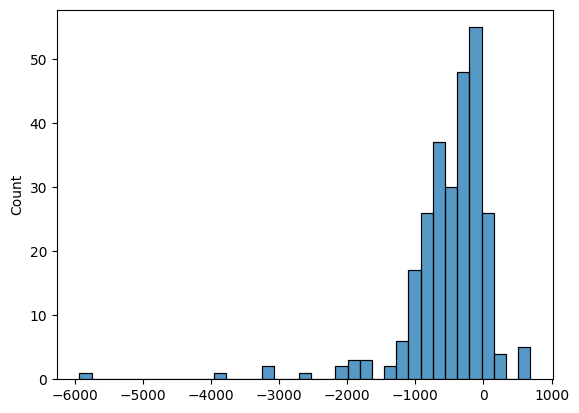

In [8]:
sns.histplot(dist_day_created)

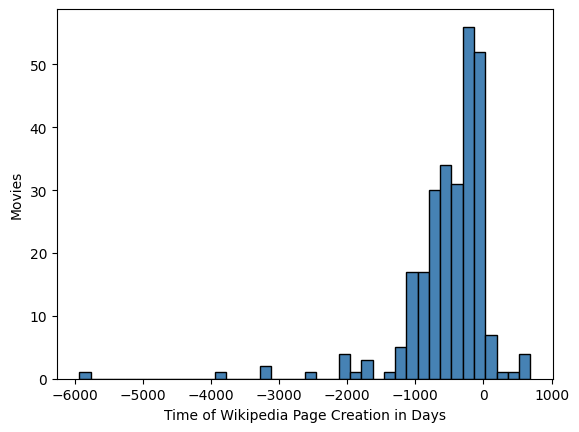

In [18]:
fig, ax = plt.subplots()

ax.hist(dist_day_created, bins=40, color='steelblue', ec='black')

ax.set_xlabel('Time of Wikipedia Page Creation in Days')
ax.set_ylabel('Movies')

plt.show()

### Retrieve Edits -500 to +100 Days

#### Retrieve list of all Wikipedia Bots first to remove bot-edits from rigor statistic

In [413]:
def get_wiki_bots(url):
    request = requests.get(url)
    soup = BeautifulSoup(request.content, 'html.parser')
    new_url = soup.find('a', href=True, string='next page')['href']
    previous_url = url

    bot_list = []

    while True:

        previous_url = new_url
        letters = soup.findAll('div', {'class' : 'mw-category mw-category-columns'})

        for entry in letters:
            bots = entry.findAll('li')

            for bot in bots:
                bot_list.append(bot.string[5:])

        try:
            new_url = soup.find('a', href=True, string='next page')['href']
        except:
            break

        request = requests.get('https://en.wikipedia.org/' + new_url)
        soup = BeautifulSoup(request.content, 'html.parser')
        
    return bot_list

In [414]:
# wiki_bots = get_wiki_bots('https://en.wikipedia.org/wiki/Category:All_Wikipedia_bots')

In [415]:
# pd.DataFrame({'bot_name' : wiki_bots}).to_csv('data/wikipedia_bots.csv', index=False)

In [416]:
wiki_bots = list(pd.read_csv('data/wikipedia_bots.csv')['bot_name'])

#### Retreive edits

In [417]:
def calculate_aggregate_edits(page_history, start, end):
    date_range = pd.date_range(start, periods=600).tolist()
    
    edit_list = []
    edits = 0
    
    i = 0
    
    while page_history[i][0] < start:
        edits += 1
        i += 1
    
    for date in date_range:
        while page_history[i][0] == date:
            edits += 1
            i += 1
            
        edit_list.append(edits)
        
    return edit_list

In [418]:
def get_pageedit_data(df, target_column, start, end):
    
    collection = []
    edits = []
    i = 0
    
    for page in df[target_column]:   
        url = f'https://en.wikipedia.org/w/api.php?action=query&prop=revisions&format=json&rvlimit=500&titles={page}'
        more_pages = ''
        
        revisions = []

        try:
            while True:
                data = requests.get(url + more_pages)
                page_id = list(data.json()['query']['pages'].keys())[0]

                revision = data.json()['query']['pages'][page_id]['revisions']

                for j in range(len(revision)):
                    timestamp = revision[j]['timestamp'][:10]
                    try:
                        comment = revision[j]['comment']
                    except:
                        comment = ''
                    try:
                        user = revision[j]['user']
                    except:
                        user = 'hidden_user'
                    if user not in wiki_bots:
                        revisions.append([datetime.strptime(timestamp, '%Y-%m-%d'), user, comment])
                
                try:
                    rvcontinue = data.json()['continue']['rvcontinue']
                    more_pages = '&rvcontinue=' + rvcontinue
                except:
                    break
            revisions = revisions[::-1]
            collection.append(revisions)
            edits.append(calculate_aggregate_edits(revisions, df[start][i], df[end][i]))
        
        except:
            print(data, page, url + more_pages)
            collection.append([])
            edits.append([0] * 600)
    
        i += 1
        
    return collection, edits

In [419]:
# page_histories, daily_edits_per_page = get_pageedit_data(df, 'wiki_page', 'cutoff_date_pre', 'cutoff_date_post')

In [420]:
test = []
for movie in daily_edits_per_page:
    test.append(len(movie))

test.count(600) # We got 600 days of edit history for all of the 269 movies!

269

In [421]:
hist_data = []
for dates in page_histories:
    data = []
    for date in dates:
        data.append([date[0].strftime('%Y-%m-%d'), date[1], date[2]])
    hist_data.append(data)

In [422]:
# with open('data/daily_edits_per_page.json', 'w', encoding='utf-8') as f:
#     json.dump(daily_edits_per_page, f, ensure_ascii=False, indent=4)
# f.close()

# with open('data/wikipedia_page_histories.json', 'w', encoding='utf-8') as f:
#     json.dump(hist_data, f, ensure_ascii=False, indent=4)
# f.close()

In [423]:
# df.to_csv('data/movies_meta_data.csv', index=False)

#### Create df containing the edit data

In [424]:
with open('data/daily_edits_per_page.json', 'r', encoding='utf-8') as f:
    daily_edits_per_page = json.loads(f.read())
f.close()

with open('data/wikipedia_page_histories.json', 'r', encoding='utf-8') as f:
    history_data = json.loads(f.read())
f.close()

In [426]:
page_histories = []
for dates in history_data:
    data = []
    for date in dates:
        data.append([datetime.strptime(date[0], '%Y-%m-%d'), date[1], date[2]])
    page_histories.append(data)

In [427]:
def get_corr_df(revenue_df, per_day_list):
    corr_df = pd.DataFrame(per_day_list, columns=list(range(-500, 100)))
    
    corr_df['opening_revenue'] = revenue_df['opening_revenue'].str.replace('$', '').str.replace(',', '').str.replace('-', 'NaN')
    corr_df['gross_revenue'] = revenue_df['gross_revenue'].str.replace('$', '').str.replace(',', '')
    
    return corr_df

In [428]:
edits_per_day_df = get_corr_df(df, daily_edits_per_page)
edits_corr = edits_per_day_df.corr().iloc[600, :600]

In [429]:
edits_per_day_df.head()

,-500,-499,-498,-497,-496,-495,-494,-493,-492,-491,...,92,93,94,95,96,97,98,99,opening_revenue,gross_revenue
0,271,271,271,271,272,272,272,272,273,274,...,5684,5687,5692,5696,5703,5709,5716,5737,260138569,804793477
1,405,405,405,405,405,405,405,405,408,411,...,2627,2631,2638,2647,2656,2660,2663,2666,75388688,224543292
2,471,473,473,473,473,476,476,478,478,478,...,1791,1791,1791,1797,1801,1802,1806,1808,90033210,213550366
3,1403,1403,1403,1409,1409,1411,1411,1411,1415,1417,...,3926,3928,3928,3932,3935,3937,3937,3938,80366312,183651655
4,1153,1153,1153,1153,1158,1159,1159,1159,1159,1159,...,3495,3496,3497,3498,3502,3502,3502,3502,71297219,164870234


In [430]:
# edits_per_day_df.to_csv('data/aggregated_edits_per_day.csv', index=False)

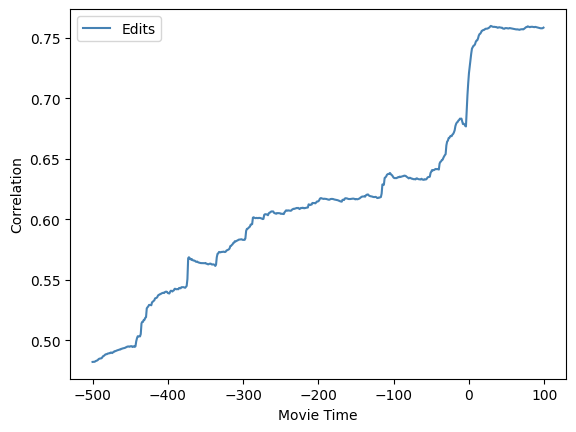

In [431]:
fig, ax = plt.subplots()

ax.plot(edits_corr, color='steelblue', label='Edits')

ax.set_xlabel('Movie Time')
ax.set_ylabel('Correlation')

ax.legend()
plt.show()

### Retrieve Rigor Statistics -500 to +100 Days (Apply Algorithm to Calulate Rigor)

In [432]:
def calculate_rigor_score(page_history, start, end):
    date_range = pd.date_range(start, periods=600).tolist()
    
    rigor_scores = []
    rigor_score = 0
    
    i = 1
    
    while page_history[i][0] < start:
        if page_history[i][1] != page_history[i-1][1]:
            rigor_score += 1
        else:
            if page_history[i][0] != page_history[i-1][0]:
                rigor_score += 1
            else:
                pass
        i += 1
    
    for date in date_range:
        while page_history[i][0] == date:
            if page_history[i][1] != page_history[i-1][1]:
                rigor_score += 1
            else:
                if page_history[i][0] != page_history[i-1][0]:
                    rigor_score += 1
                else:
                    pass
            i += 1
        rigor_scores.append(rigor_score)
        
    return rigor_scores

In [433]:
daily_rigor_per_page = []
i = 0

for page in page_histories:
    try:
        daily_rigor_per_page.append(calculate_rigor_score(page, df['cutoff_date_pre'][i], df['cutoff_date_post'][i]))
    except:
        daily_rigor_per_page.append([0] * 600)
    i += 1

In [434]:
rigor_per_day_df = get_corr_df(df, daily_rigor_per_page)
rigor_corr = rigor_per_day_df.corr().iloc[600, :600]

In [435]:
rigor_per_day_df.head()

,-500,-499,-498,-497,-496,-495,-494,-493,-492,-491,...,92,93,94,95,96,97,98,99,opening_revenue,gross_revenue
0,174,174,174,174,175,175,175,175,176,177,...,4235,4238,4243,4247,4251,4257,4263,4278,260138569,804793477
1,296,296,296,296,296,296,296,296,299,301,...,1975,1978,1984,1991,2000,2004,2006,2009,75388688,224543292
2,357,359,359,359,359,361,361,363,363,363,...,1352,1352,1352,1356,1359,1360,1364,1366,90033210,213550366
3,1069,1069,1069,1073,1073,1075,1075,1075,1079,1081,...,2909,2911,2911,2914,2917,2919,2919,2920,80366312,183651655
4,865,865,865,865,868,869,869,869,869,869,...,2646,2647,2648,2649,2652,2652,2652,2652,71297219,164870234


In [436]:
# rigor_per_day_df.to_csv('data/aggregated_rigor_per_day.csv', index=False)

In [437]:
daily_theaters_per_movie = [[x] * 600 for x in list(corr_df['n_theaters'])]

In [438]:
theaters_per_day_df = get_corr_df(corr_df, daily_theaters_per_movie)
theaters_corr = theaters_per_day_df.corr().iloc[600, :600]

In [439]:
theaters_per_day_df.head()

,-500,-499,-498,-497,-496,-495,-494,-493,-492,-491,...,92,93,94,95,96,97,98,99,opening_revenue,gross_revenue
0,4336,4336,4336,4336,4336,4336,4336,4336,4336,4336,...,4336,4336,4336,4336,4336,4336,4336,4336,260138569,804793477
1,4300,4300,4300,4300,4300,4300,4300,4300,4300,4300,...,4300,4300,4300,4300,4300,4300,4300,4300,75388688,224543292
2,4225,4225,4225,4225,4225,4225,4225,4225,4225,4225,...,4225,4225,4225,4225,4225,4225,4225,4225,90033210,213550366
3,4160,4160,4160,4160,4160,4160,4160,4160,4160,4160,...,4160,4160,4160,4160,4160,4160,4160,4160,80366312,183651655
4,4090,4090,4090,4090,4090,4090,4090,4090,4090,4090,...,4090,4090,4090,4090,4090,4090,4090,4090,71297219,164870234


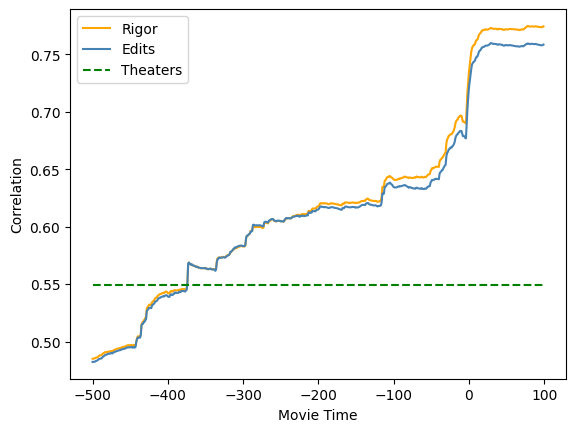

In [440]:
fig, ax = plt.subplots()

ax.plot(rigor_corr, color='orange', label='Rigor')
ax.plot(edits_corr, color='steelblue', label='Edits')
ax.plot(theaters_corr, color='green', label='Theaters', linestyle='dashed')

ax.set_xlabel('Movie Time')
ax.set_ylabel('Correlation')

ax.legend()
plt.show()

### Retrieve Users -500 to +100 Days

In [441]:
def calculate_aggregate_users(page_history, start, end):
    date_range = pd.date_range(start, periods=600).tolist()
    
    users = []
    n_users = 0
    user_scores = []
    
    i = 1
    
    while page_history[i][0] < start:
        if page_history[i][1] not in users:
            users.append(page_history[i][1])
            n_users += 1
        else:
            pass
        
        i += 1
    
    for date in date_range:
        while page_history[i][0] == date:
            if page_history[i][1] not in users:
                users.append(page_history[i][1])
                n_users += 1
            else:
                pass
            
            i += 1
        user_scores.append(n_users)
        
    return user_scores

In [442]:
daily_users_per_page = []
i = 0

for page in page_histories:
    try:
        daily_users_per_page.append(calculate_aggregate_users(page, df['cutoff_date_pre'][i], df['cutoff_date_post'][i]))
    except:
        daily_users_per_page.append([0] * 600)
    i += 1

In [443]:
users_per_day_df = get_corr_df(df, daily_users_per_page)
users_corr = users_per_day_df.corr().iloc[600, :600]
users_per_day_df.head()

,-500,-499,-498,-497,-496,-495,-494,-493,-492,-491,...,92,93,94,95,96,97,98,99,opening_revenue,gross_revenue
0,45,45,45,45,45,45,45,45,46,46,...,739,739,739,739,740,741,741,744,260138569,804793477
1,73,73,73,73,73,73,73,73,74,74,...,559,559,561,565,567,569,570,570,75388688,224543292
2,168,169,169,169,169,170,170,172,172,172,...,423,423,423,423,424,424,424,425,90033210,213550366
3,329,329,329,331,331,332,332,332,335,337,...,798,798,798,799,800,800,800,800,80366312,183651655
4,310,310,310,310,312,312,312,312,312,312,...,770,771,772,773,774,774,774,774,71297219,164870234


In [444]:
# users_per_day_df.to_csv('data/aggregated_users_per_day.csv', index=False)

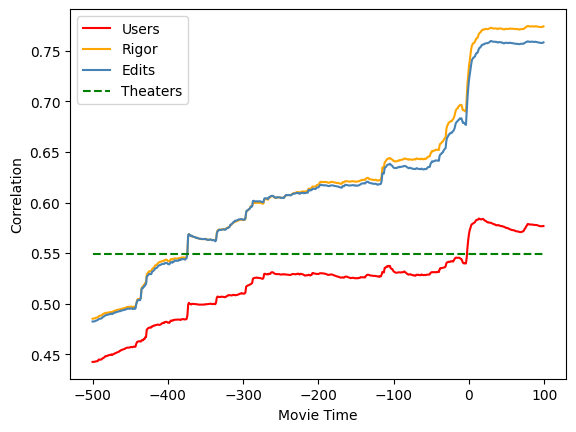

In [73]:
fig, ax = plt.subplots()

ax.plot(users_corr, color='red', label='Users')
ax.plot(rigor_corr, color='orange', label='Rigor')
ax.plot(edits_corr, color='steelblue', label='Edits')
ax.plot(theaters_corr, color='green', label='Theaters', linestyle='dashed')

ax.set_xlabel('Movie Time')
ax.set_ylabel('Correlation')

ax.legend()
plt.show()

### Retrieve Pageviews -500 to +100 Days (Error for movies where page created +100 days after release)

#### Retrieve as many past names of each Wikipedia page as possible (pageviews are not accredited to new page titles)

In [452]:
# pattern = r'(?<=moved page ).*\[\[(.*?)\]\]'
# pattern = r'\[\[(.*?)\]\](?=.*moved page)'
# pattern = '\[\[(.*?)\]\]'
pattern = r'(?<=moved page) \[\[(.*?)\]\](?:.*\[\[(.*?)\]\])*'

no_title_moves = ['WP', 'Talk', 'User', 'Special', 'MOS', 'Comfy21']

alternate_titles = []

for page in page_histories:
    alternate_page_title = []
    for line in page:
        result = re.findall(pattern, line[2])
        if result != []:
            for i in result[0]:
                if i not in alternate_page_title and not i.startswith(tuple(no_title_moves)):
                    alternate_page_title.append(i)
    alternate_titles.append(alternate_page_title)

In [453]:
len(alternate_titles) # matches number of movies in data frame

269

In [454]:
alternate_titles[120]

[]

#### Rertrieve the pageviews for each 'version' of each Wikipedia page and merge the views for each movie

Example API Query:<br>
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/Spider-Man:_No_Way_Home/daily/20200804/20210327

In [455]:
df.head(1)

,title,gross_revenue,n_theaters,opening_revenue,release_date,wiki_page,page_created_date,cutoff_date_pre,cutoff_date_post
0,Spider-Man: No Way Home,"$804,793,477","4,336","$260,138,569",2021-12-17,Spider-Man:_No_Way_Home,2016-11-10,2020-08-04,2022-03-27


In [456]:
def get_pageviews(df, alternate_titles, page_creation, end):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    pageviews_all = []
    i = 0
    
    url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/'

    for page in df['wiki_page']:
        pageviews_movie = []
        pageviews_page = []
        
        pre = df[page_creation][i].strftime('%Y%m%d')
        post = df[end][i].strftime('%Y%m%d')
        
        ending = f'/daily/{pre}/{post}'
        try:
            data_raw = requests.get(url + page + ending, headers=headers)
            data = data_raw.json()
        except:
            print('I:', i, page, url + page + ending, data)
        try:
            for date in data['items']:
                pageviews_page.append([datetime.strptime(date['timestamp'], '%Y%m%d%H'), date['views']])
                
        except:
            pageviews_page.append([datetime(2000, 1, 1), 0])
            print('II:', i, page, data)

        pageviews_movie.append(pageviews_page)
        
        for title in alternate_titles[i]:
            data_raw = requests.get(url + title + ending, headers=headers)
            data = data_raw.json()
            pageviews_page = []
            
            try:
                for date in data['items']:
                    pageviews_page.append([datetime.strptime(date['timestamp'], '%Y%m%d%H'), date['views']])
            
            except:
                pageviews_page.append([datetime(2000, 1, 1), 0])
                print('III:', i, title, data)
            
            if pageviews_page not in pageviews_movie:
                pageviews_movie.append(pageviews_page)
            
        pageviews_all.append(pageviews_movie)
        i += 1
    return pageviews_all

In [457]:
all_titles_all_pageviews = get_pageviews(df, alternate_titles, 'page_created_date', 'cutoff_date_post')

III: 22 Draft:Untitled Ridley Scott/Lady Gaga Gucci murder film {'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found#route', 'title': 'Not found.', 'method': 'get', 'uri': '/wikimedia.org/v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/Draft%3AUntitled%20Ridley%20Scott/Lady%20Gaga%20Gucci%20murder%20film/daily/20191101/20220304'}
III: 26 Draft:Move/The Forever Purge {'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found#route', 'title': 'Not found.', 'method': 'get', 'uri': '/wikimedia.org/v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/Draft%3AMove/The%20Forever%20Purge/daily/20190918/20211010'}
III: 42 Variety (website)|Variety {'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found', 'title': 'Not found.', 'method': 'get', 'detail': 'The date(s) you used are valid, but we either do not have data for those date(s), or the project you asked for is not loaded yet.  Please check https://wikimedia.org/api/rest_v1/?doc for more

In [458]:
def create_daterange_views(data, start, end):
    
    date_range = pd.date_range(start, end)
    df_dates = pd.DataFrame(date_range, columns=['date'])
    i = 0
    
    for page in data:
        df = pd.DataFrame(page, columns=['date', 'views'])
    
        merge = df_dates.merge(df, on='date', how='left').fillna(0)
        
        df_dates[i] = merge['views']
        i += 1
    
    df_dates['views'] = df_dates.sum(axis=1, numeric_only=True)
    
    output = []
    
    for i in range(len(df_dates)):
        output.append([df_dates['date'][i], df_dates['views'][i]])
    
    return output

In [459]:
pageviews = []

for i in range(len(all_titles_all_pageviews)):
    pageviews.append(create_daterange_views(all_titles_all_pageviews[i], df['page_created_date'][i], df['cutoff_date_post'][i]))

In [460]:
len(pageviews)

269

In [461]:
def calculate_aggregate_pageviews(pageviews_raw, df):
    
    pageviews_all = []
    
    for i in range(len(df)):
        pageviews_movie = []
        n_views = 0
        
        start = df['cutoff_date_pre'][i]
        
        date_range = pd.date_range(start, periods=600).tolist()
        
        j = 0
       
        try:
            while pageviews_raw[i][j][0] < start:
                n_views += pageviews_raw[i][j][1]
                j += 1
                
        except:
            pageviews_movie.append(n_views)
            
        try:    
            for date in date_range:
                while pageviews_raw[i][j][0] == date:
                    n_views += pageviews_raw[i][j][1]
                    j += 1

                pageviews_movie.append(n_views)
                
        except:
            pass
            
        pageviews_all.append(pageviews_movie)
        
    return pageviews_all

In [462]:
aggregate_pageviews_per_day = calculate_aggregate_pageviews(pageviews, df)

In [463]:
len(aggregate_pageviews_per_day)

269

In [464]:
pageviews_per_day_df = get_corr_df(df, aggregate_pageviews_per_day)
pageviews_corr = pageviews_per_day_df.corr().iloc[600, :600]

In [465]:
pageviews_per_day_df.head()

,-500,-499,-498,-497,-496,-495,-494,-493,-492,-491,...,92,93,94,95,96,97,98,99,opening_revenue,gross_revenue
0,26659.0,26717.0,26809.0,26879.0,26975.0,27066.0,27156.0,27232.0,27324.0,27426.0,...,28800611.0,28880311.0,28939493.0,28988298.0,29032791.0,29077280.0,29121665.0,29174361.0,260138569,804793477
1,477758.0,483011.0,487926.0,492800.0,499149.0,505398.0,510856.0,516103.0,521016.0,525785.0,...,14171376.0,14213176.0,14246598.0,14278854.0,14306563.0,14329849.0,14354528.0,14387094.0,75388688,224543292
2,1091945.0,1095679.0,1099647.0,1103764.0,1108705.0,1113519.0,1118178.0,1122047.0,1125608.0,1128819.0,...,10193205.0,10226150.0,10252865.0,10275837.0,10296037.0,10316879.0,10336745.0,10360134.0,90033210,213550366
3,3305666.0,3313378.0,3321186.0,3328614.0,3337040.0,3347149.0,3356855.0,3365846.0,3374739.0,3384651.0,...,16372661.0,16443902.0,16488464.0,16519011.0,16545309.0,16569164.0,16596360.0,16635480.0,80366312,183651655
4,3432364.0,3437719.0,3442655.0,3447587.0,3453579.0,3461237.0,3467761.0,3473208.0,3478698.0,3483895.0,...,21667863.0,21713600.0,21743645.0,21766723.0,21787877.0,21807640.0,21828818.0,21857713.0,71297219,164870234


In [467]:
# pageviews_per_day_df.to_csv('data/aggregated_pageviews_per_day.csv', index=False)

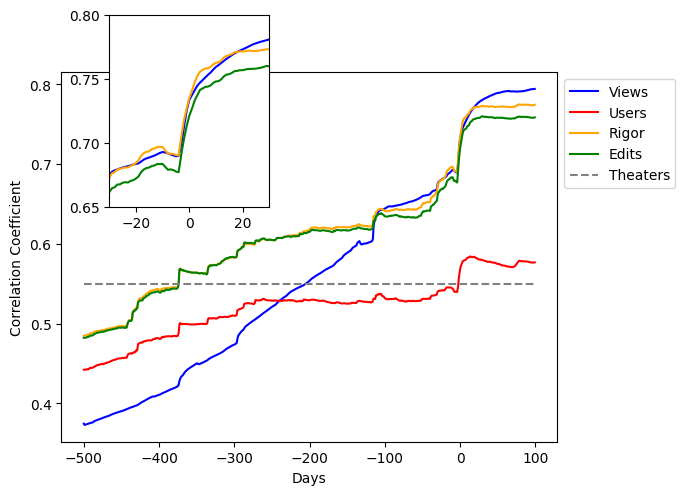

In [466]:
fig, ax = plt.subplots()

ax.plot(pageviews_corr, color='blue', label='Views')
ax.plot(users_corr, color='red', label='Users')
ax.plot(rigor_corr, color='orange', label='Rigor')
ax.plot(edits_corr, color='green', label='Edits')
ax.plot(theaters_corr, color='grey', label='Theaters', linestyle='dashed')

ax.set_xlabel('Days')
ax.set_ylabel('Correlation Coefficient')

ax.legend(bbox_to_anchor=(1, 1))

# Create a new axis inside the original one
ax2 = fig.add_axes([0.2, 0.6, 0.25, 0.4])

# Plot the zoomed region on the new axis
ax2.plot(pageviews_corr, color='blue')
ax2.plot(users_corr, color='red')
ax2.plot(rigor_corr, color='orange')
ax2.plot(edits_corr, color='green')
ax2.plot(theaters_corr, color='grey', linestyle='dashed')

# Set the limits of the new axis to zoom in
ax2.set_xlim(-30, 30)
ax2.set_ylim(0.65, 0.8)


plt.show()

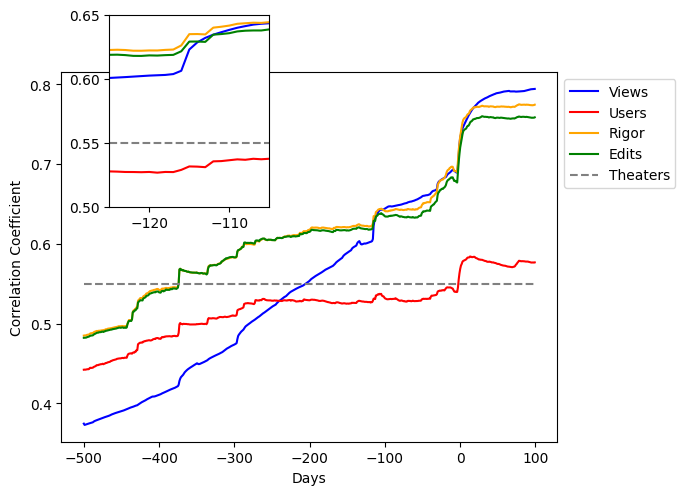

In [597]:
fig, ax = plt.subplots()

ax.plot(pageviews_corr, color='blue', label='Views')
ax.plot(users_corr, color='red', label='Users')
ax.plot(rigor_corr, color='orange', label='Rigor')
ax.plot(edits_corr, color='green', label='Edits')
ax.plot(theaters_corr, color='grey', label='Theaters', linestyle='dashed')

ax.set_xlabel('Days')
ax.set_ylabel('Correlation Coefficient')

ax.legend(bbox_to_anchor=(1, 1))

# Create a new axis inside the original one
ax2 = fig.add_axes([0.2, 0.6, 0.25, 0.4])

# Plot the zoomed region on the new axis
ax2.plot(pageviews_corr, color='blue')
ax2.plot(users_corr, color='red')
ax2.plot(rigor_corr, color='orange')
ax2.plot(edits_corr, color='green')
ax2.plot(theaters_corr, color='grey', linestyle='dashed')

# Set the limits of the new axis to zoom in
ax2.set_xlim(-125, -105)
ax2.set_ylim(0.5, 0.65)


plt.show()

#### Can it be that the number of theaters has such a 'low' correlation coefficient?! Yes...

In [550]:
corr_df['n_theaters'] = pd.to_numeric(corr_df['n_theaters'], errors='coerce')
corr_df['opening_revenue'] = pd.to_numeric(corr_df['opening_revenue'], errors='coerce')

In [551]:
corr_df['n_theaters'].corr(corr_df['opening_revenue'])

0.5492823678893406

### Train the Regression Models

In [151]:
df.head(3)

,title,gross_revenue,n_theaters,opening_revenue,release_date,wiki_page,page_created_date,cutoff_date_pre,cutoff_date_post
0,Spider-Man: No Way Home,"$804,793,477","4,336","$260,138,569",2021-12-17,Spider-Man:_No_Way_Home,2016-11-10,2020-08-04,2022-03-27
1,Shang-Chi and the Legend of the Ten Rings,"$224,543,292","4,300","$75,388,688",2021-09-03,Shang-Chi_and_the_Legend_of_the_Ten_Rings,2018-12-03,2020-04-21,2021-12-12
2,Venom: Let There Be Carnage,"$213,550,366","4,225","$90,033,210",2021-10-01,Venom:_Let_There_Be_Carnage,2018-11-23,2020-05-19,2022-01-09


#### Edits

In [468]:
edits_df = pd.read_csv('data/aggregated_edits_per_day.csv')
rigor_df = pd.read_csv('data/aggregated_rigor_per_day.csv')
users_df = pd.read_csv('data/aggregated_users_per_day.csv')
pageviews_df = pd.read_csv('data/aggregated_pageviews_per_day.csv')

In [707]:
def regression_result(df, n_days=600, start=-500, output_type='df', log=True):
    
    y = edits_df['opening_revenue'].values.reshape(-1, 1)

    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = imputer.fit(y)
    y_imputed = imputer.transform(y)
    
    if log:
        y_imputed = np.log(y_imputed)

    model = LinearRegression()

    scores = []

    for i in range(start, start + n_days):
        X = df.iloc[:, i].values.reshape(-1, 1)
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        if np.isnan(X).any():
            X_imputed = imputer.fit_transform(X)
        else:
            X_imputed = X
            
        if log:
            X_imputed = np.log(np.add(X_imputed, 1))
        
        model.fit(X_imputed, y_imputed)
        
        scores.append(model.score(X_imputed, y_imputed))
    
    if output_type == 'df':
        out_df = pd.DataFrame({'r2' : scores})
        out_df.index = pd.RangeIndex(start=start, stop=start + n_days, step=1)
        return out_df
    else:
        return scores

In [708]:
reg_pageviews = regression_result(pageviews_df)
reg_users = regression_result(users_df)
reg_rigor = regression_result(rigor_df)
reg_edits = regression_result_windowed(edits_df)

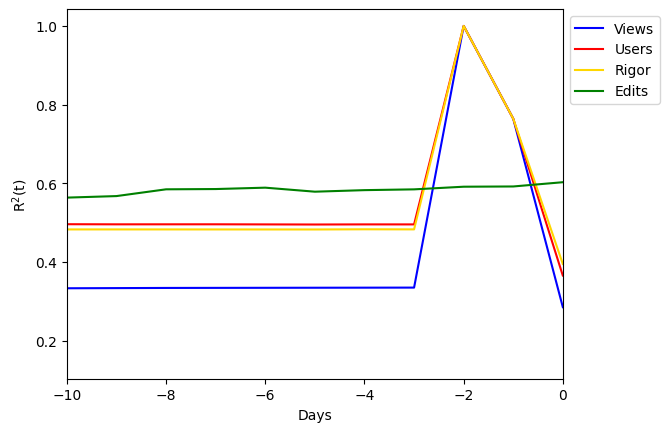

In [716]:
fig, ax = plt.subplots()

ax.plot(reg_pageviews, color='blue', label='Views')
ax.plot(reg_users, color='red', label='Users')
ax.plot(reg_rigor, color='gold', label='Rigor')
ax.plot(reg_edits, color='green', label='Edits')

ax.set_xlabel('Days')
ax.set_ylabel('R$^2$(t)')

ax.set_xlim([-10, 0])

ax.legend(bbox_to_anchor=(1, 1))

plt.show()

#### Theaters

In [374]:
theaters_per_day_df = theaters_per_day_df.apply(pd.to_numeric, errors='coerce')

In [385]:
reg_theaters = regression_result(theaters_per_day_df, 1, -500, output_type='scores')
reg_theaters = [reg_theaters] * 600

In [515]:
theaters_df = pd.DataFrame(reg_theaters)
theaters_df.index = pd.RangeIndex(start=-500, stop=100, step=1)

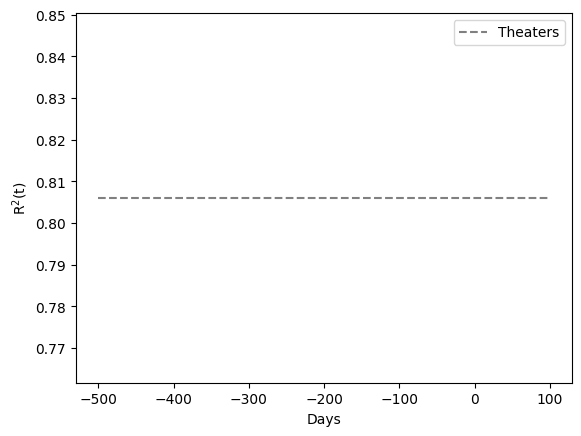

In [516]:
fig, ax = plt.subplots()

ax.plot(theaters_df, color='grey', label='Theaters', linestyle='dashed')

ax.set_xlabel('Days')
ax.set_ylabel('R$^2$(t)')

ax.legend(bbox_to_anchor=(1, 1))

plt.show()

## Test

In [989]:
df = pd.read_csv('data/movies_meta_data.csv')
df['wiki_page'] = df['wiki_page'].str.replace('/', '%2F') # replace URL reserved character '/'
df.head()

corr_df = df.copy()
corr_df['opening_revenue'] = corr_df['opening_revenue'].str.replace('$', '').str.replace(',', '').str.replace('-', 'NaN')
corr_df['gross_revenue'] = corr_df['gross_revenue'].str.replace('$', '').str.replace(',', '')
corr_df['n_theaters'] = corr_df['n_theaters'].str.replace(',', '').str.replace('-', 'NaN')

In [530]:
def regression_result_windowed(df, window=100, output_type='df', log=True):
    
    y = edits_df['opening_revenue'].values.reshape(-1, 1)

    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = imputer.fit(y)
    y_imputed = imputer.transform(y)
    if log:
        y_imputed = np.log(y_imputed)

    model = LinearRegression()

    scores = []

    for i in range(window, 600):
        X = df.iloc[:, i-window:i].to_numpy()
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        if np.isnan(X).any():
            X_imputed = imputer.fit_transform(X)
        else:
            X_imputed = X
        
        if log:
            X_imputed = np.log(np.add(X_imputed, 1))
        
        model.fit(X_imputed, y_imputed)
        
        scores.append(model.score(X_imputed, y_imputed))
#         scores.append(cross_val_score(model, X_imputed, y_imputed, scoring='r2').mean())
    
    if output_type == 'df':
        out_df = pd.DataFrame({'r2' : scores})
        out_df.index = pd.RangeIndex(start=-500 + window, stop=100, step=1)
        return out_df
    else:

        return scores

In [531]:
reg_pageviews = regression_result_windowed(pageviews_df)
reg_users = regression_result_windowed(users_df)
reg_rigor = regression_result_windowed(rigor_df)
reg_edits = regression_result_windowed(edits_df)

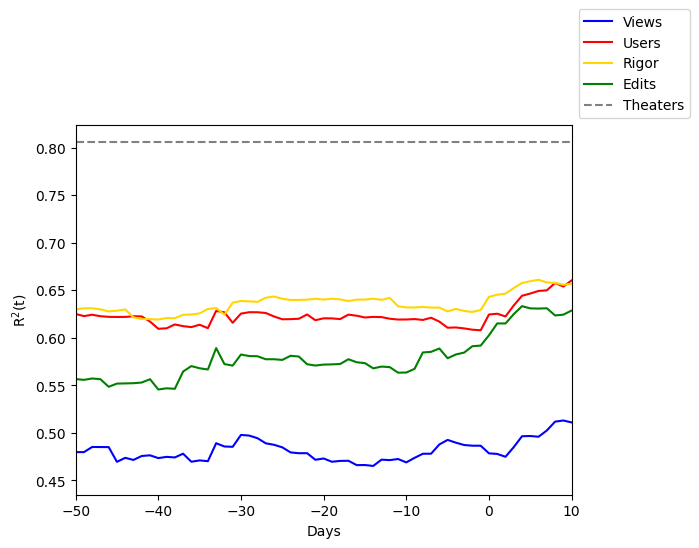

In [673]:
fig, ax = plt.subplots()

ax.plot(reg_pageviews, color='blue', label='Views')
ax.plot(reg_users, color='red', label='Users')
ax.plot(reg_rigor, color='gold', label='Rigor')
ax.plot(reg_edits, color='green', label='Edits')
ax.plot(theaters_df, color='grey', label='Theaters', linestyle='dashed')

ax.set_xlabel('Days')
ax.set_ylabel('R$^2$(t)')

ax.set_xlim([-50, 10])

ax.legend(bbox_to_anchor=(1, 1))

plt.show()

## Looking Good!

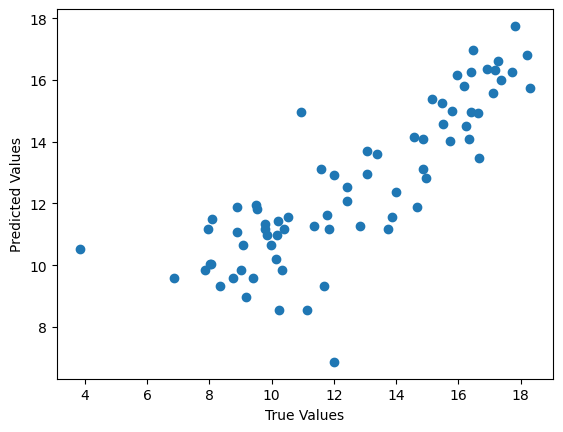

In [814]:
X = test.iloc[:, 1].values.reshape(-1, 1)
y = test['opening_revenue'].values.reshape(-1, 1)

X = np.log(X)
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [971]:
def get_set_regressions(set_id = 'T', day = -30, log = True, cv=False):
    
    df = pd.concat([pageviews_df[f'{day}'], users_df[f'{day}'], rigor_df[f'{day}'], edits_df[f'{day}'], corr_df['n_theaters'], corr_df['opening_revenue']], axis=1)
    df.columns.values[0] = 'views'
    df.columns.values[1] = 'users'
    df.columns.values[2] = 'rigor'
    df.columns.values[3] = 'edits'
    
    
    df['n_theaters'] = pd.to_numeric(df['n_theaters'], errors='coerce')
    df['opening_revenue'] = pd.to_numeric(df['opening_revenue'], errors='coerce')
    
    df.dropna(axis=0, inplace=True)
    df = df.reset_index(drop=True)
    
    model = LinearRegression()
    
    y = df['opening_revenue'].values.reshape(-1, 1)
    if log:
        df = df.replace(0, 1)
        y = np.log(y)
    
    if set_id == 'T':
        
        X = df['n_theaters'].values.reshape(-1, 1)
        if log:
            X = np.log(X)
            
        model.fit(X, y)
        
        if cv:
            return cross_val_score(model, X, y, scoring = 'r2', cv=10).mean()
            
        return model.score(X, y)
    
    elif set_id == 'V':
    
        X = df['views'].values.reshape(-1, 1)
        if log:
            X = np.log(X)
            
        model.fit(X, y)
        
        if cv:
            return cross_val_score(model, X, y, scoring = 'r2', cv=10).mean()
        
        return model.score(X, y)
    
    elif set_id == 'VT':
    
        x = pd.concat([df['views'], df['n_theaters']], axis=1)
    
        X = x.to_numpy()
        if log:
            X = np.log(X)
            
        model.fit(X, y)
        
        if cv:
            return cross_val_score(model, X, y, scoring = 'r2', cv=10).mean()
        
        return model.score(X, y)
    
    elif set_id == 'U':
    
        X = df['users'].values.reshape(-1, 1)
        if log:
            X = np.log(X)
            
        model.fit(X, y)
        
        if cv:
            return cross_val_score(model, X, y, scoring = 'r2', cv=10).mean()
        
        return model.score(X, y)
    
    elif set_id == 'R':
    
        X = df['rigor'].values.reshape(-1, 1)
        if log:
            X = np.log(X)
            
        model.fit(X, y)
        
        if cv:
            return cross_val_score(model, X, y, scoring = 'r2', cv=10).mean()
        
        return model.score(X, y)
    
    elif set_id == 'UT':
    
        x = pd.concat([df['users'], df['n_theaters']], axis=1)
    
        X = x.to_numpy()
        if log:
            X = np.log(X)
            
        model.fit(X, y)
        
        if cv:
            return cross_val_score(model, X, y, scoring = 'r2', cv=10).mean()
        
        return model.score(X, y)
    
    elif set_id == 'VURE':
    
        x = pd.concat([df['views'], df['users'], df['rigor'], df['edits']], axis=1)
    
        X = x.to_numpy()
        if log:
            X = np.log(X)
            
        model.fit(X, y)
        
        if cv:
            return cross_val_score(model, X, y, scoring = 'r2', cv=10).mean()
        
        return model.score(X, y)
    
    elif set_id == 'VURET':
    
        x = pd.concat([df['views'], df['users'], df['rigor'], df['edits'], df['n_theaters']], axis=1)
    
        X = x.to_numpy()
        if log:
            X = np.log(X)
            
        model.fit(X, y)
        
        if cv:
            return cross_val_score(model, X, y, scoring = 'r2', cv=10).mean()
        
        return model.score(X, y)
            
    else:    
        return df

In [992]:
logs = []
non_logs = []

for i in ['T', 'V', 'VT', 'U', 'R', 'UT', 'VURE', 'VURET']:
    i_logs = []
    i_non_logs = []
    for k in [False, True]:
        k_logs = []
        k_non_logs = []
        for j in range(-500, 100):
            k_logs.append(get_set_regressions(set_id=i, day=j, cv=k))
            k_non_logs.append(get_set_regressions(set_id=i, day=j, log=False, cv=k))
        i_logs.append(k_logs)
        i_non_logs.append(k_non_logs)
    logs.append(i_logs)
    non_logs.append(i_non_logs)

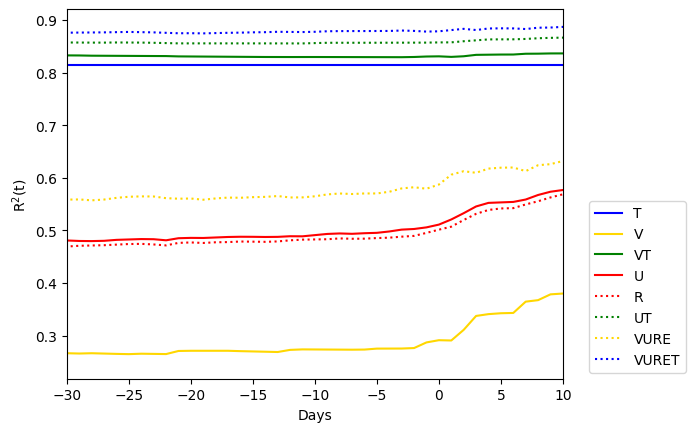

In [1121]:
fig, ax = plt.subplots()

ax.plot(range(-500, 100), logs[0][0], color='blue', label='T')
ax.plot(range(-500, 100), logs[1][0], color='gold', label='V')
ax.plot(range(-500, 100), logs[2][0], color='green', label='VT')
ax.plot(range(-500, 100), logs[3][0], color='red', label='U')
ax.plot(range(-500, 100), logs[4][0], color='red', label='R', linestyle='dotted')
ax.plot(range(-500, 100), logs[5][0], color='green', label='UT', linestyle='dotted')
ax.plot(range(-500, 100), logs[6][0], color='gold', label='VURE', linestyle='dotted')
ax.plot(range(-500, 100), logs[7][0], color='blue', label='VURET', linestyle='dotted')

ax.set_xlabel('Days')
ax.set_ylabel('R$^2$(t)')

# ax.set_title('R$^2$ of Linear Regression Model by Set of Variables (no CV)')

ax.set_xlim([-30, 10])

ax.legend(bbox_to_anchor=(1.15, 0.5))

plt.show()

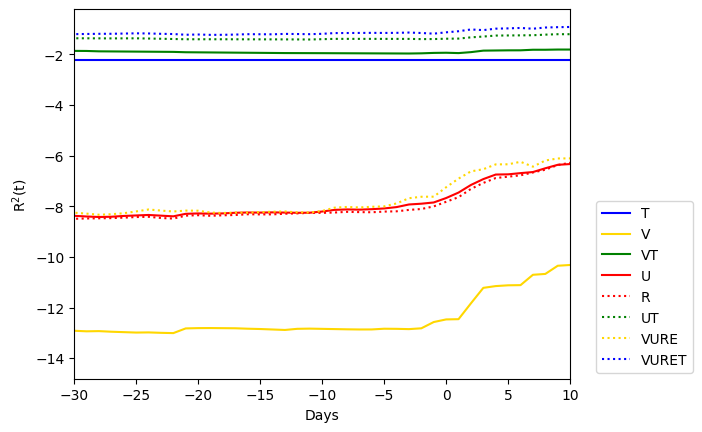

In [1122]:
fig, ax = plt.subplots()

ax.plot(range(-500, 100), logs[0][1], color='blue', label='T')
ax.plot(range(-500, 100), logs[1][1], color='gold', label='V')
ax.plot(range(-500, 100), logs[2][1], color='green', label='VT')
ax.plot(range(-500, 100), logs[3][1], color='red', label='U')
ax.plot(range(-500, 100), logs[4][1], color='red', label='R', linestyle='dotted')
ax.plot(range(-500, 100), logs[5][1], color='green', label='UT', linestyle='dotted')
ax.plot(range(-500, 100), logs[6][1], color='gold', label='VURE', linestyle='dotted')
ax.plot(range(-500, 100), logs[7][1], color='blue', label='VURET', linestyle='dotted')

ax.set_xlabel('Days')
ax.set_ylabel('R$^2$(t)')

# ax.set_title('R$^2$ of Linear Regression Model by Set of Variables (with CV)')

ax.set_xlim([-30, 10])

ax.legend(bbox_to_anchor=(1.15, 0.5))

plt.show()

In [1064]:
test = get_set_regressions(set_id='x')
len(test['opening_revenue'])

242

In [1128]:
def pred_true_scatter(log = True):

    df = get_set_regressions(set_id='x')

    y = df['opening_revenue']
    
    X = df.iloc[:, :-1].to_numpy()
    
    if log:
        X = np.log(X)
        y = np.log(y)
        
    model = LinearRegression()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    fig, ax = plt.subplots()
    
    ax.scatter(y_train, y_pred, color='steelblue', label=f'Sample of {len(df)} Movies')
    ax.plot(y_train, y_train, color='red', label='Optima')
    
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    
#     ax.set_title('True vs. Predicted Opening Weekend Revenue')
    
    ax.legend(bbox_to_anchor=(.38, 1), framealpha=.2)
    
    plt.savefig('figures/true_pred.png')

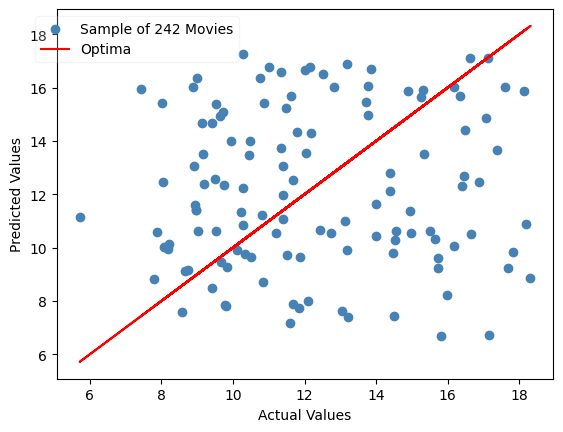

In [1129]:
pred_true_scatter()